## Comparisons

## 1 . Rod Data (Cyan)
Pure tungsten and Rieth tungsten with WL10 alloy
Goal - (1) demonstrate trend + effect of alloying for rod tungsten
        (2) lowest temperature available creep data


## 2. Wire Data (Green)
Pure tungsten, K-doped tungsten
Goal - Demonstrate effect of 
    (1) K-doping
    (1) Recrystallization

## 3. Sheet data (Red)
Pure tungssten, sintered and W-25$ Re alloy
Goals - (1) demonstrate braod trend for tungsten with most plentiful data sources  
        (2) Show effect of W-25% Re alloying

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
sys.path.append('../')
from common_util import ProjectPaths,setup_axis_default,setup_plotting_format
paths = ProjectPaths()
setup_plotting_format()
from creeplib import LarsonMillerPowerLaw, LarsonMillerPowerLawMulti
from typing import List


PSI_TO_MPA = 0.00689476
HOURS_TO_SECONDS = 3600
KGMM2_TO_MPA = 9.80665         


def convert_stress(data: pd.Series):
    if 'psi' in data.name.lower():
        return data * PSI_TO_MPA
    elif 'ksi' in data.name.lower():
        return data * PSI_TO_MPA * 1000
    elif 'kg' in data.name.lower():
        return data * KGMM2_TO_MPA
    elif 'mpa' in data.name.lower():
        return data
    else:
        raise ValueError('cannot convert stress units')

def convert_temperature(data: pd.Series):
    if 'F' in data.name:
        return (data - 32) * 5/9
    elif 'C' in data.name:
        return data
    elif 'K' in data.name:
        return data - 273.15
    else:
        raise ValueError('cannot convert temperature units')

def convert_time(data: pd.Series):
    if 'hr' in data.name.lower():
        return data * HOURS_TO_SECONDS
    if 'min' in data.name.lower():
        return data * 60

def get_column_with_expr(columns: List[str], expr: List[str]) -> str:
    if isinstance(expr, str):
        expr = [expr]
    
    for col in columns:
        if np.all([e in col for e in expr]):
            return col
        
    return None

def get_creep_rupture_data(data: pd.DataFrame):
    stress_col = get_column_with_expr(data.columns, 'Stress')
    temp_col = get_column_with_expr(data.columns, 'Temperature')
    rupture_col = get_column_with_expr(data.columns, ['Rupture','Time'])

    data = np.array([
        convert_stress(data[stress_col].astype(np.float64)),
        convert_temperature(data[temp_col].astype(np.float64)),
        convert_time(data[rupture_col].astype(np.float64))
    ])

    return pd.DataFrame(data.T, columns=['Stress [MPa]', 'Temperature [C]', 'Rupture Time [s]'])


### Overall Fit

Perform an overall fit, visually inspect for data sources that appear to be outliers.

                      lower         upper
C              1.117728e+01  1.440704e+01
A_1_source0    4.873353e+21  3.988552e+23
beta_source0  -4.780675e+00 -4.364898e+00
A_1_source1    1.314609e+26  4.485310e+29
beta_source1  -6.072914e+00 -5.331412e+00
A_1_source2    1.783417e+30  3.781518e+33
beta_source2  -6.906589e+00 -6.195665e+00
A_1_source3    2.104482e+20  5.625013e+23
beta_source3  -4.785123e+00 -4.057276e+00
A_1_source4    6.057443e+17  1.353975e+21
beta_source4  -4.244056e+00 -3.500561e+00
A_1_source5    3.446469e+12  2.475659e+24
beta_source5  -4.949087e+00 -2.404346e+00
A_1_source6    2.897186e+12  9.568390e+37
beta_source6  -7.917868e+00 -2.302899e+00
A_1_source7    3.692856e+01  4.279176e+44
beta_source7  -9.367710e+00  8.947215e-02
A_1_source8    4.994373e+19  9.402147e+30
beta_source8  -6.420881e+00 -3.923267e+00
A_1_source9    4.291226e+20  3.411087e+24
beta_source9  -4.904914e+00 -4.103740e+00
A_1_source10   4.000000e+01  7.709727e+45
beta_source10 -9.450872e+00  1.960

/tmp/ipykernel_16491/4111731861.py:90: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipykernel_16491/4111731861.py:90: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/home/mlanahan/Documents/projects/modeling_tungsten/engineering_models/modeling/creeplib.py:1047: RuntimeWarning: overflow encountered in power
  S_pred_b = np.exp(alpha_b) * (Z ** beta_b)
/home/mlanahan/Documents/projects/modeling_tungsten/engineering_models/modeling/creeplib.py:1047: RuntimeWarning: invalid value encountered in multiply
  S_pred_b = np.exp(alpha_b) * (Z ** beta_b)


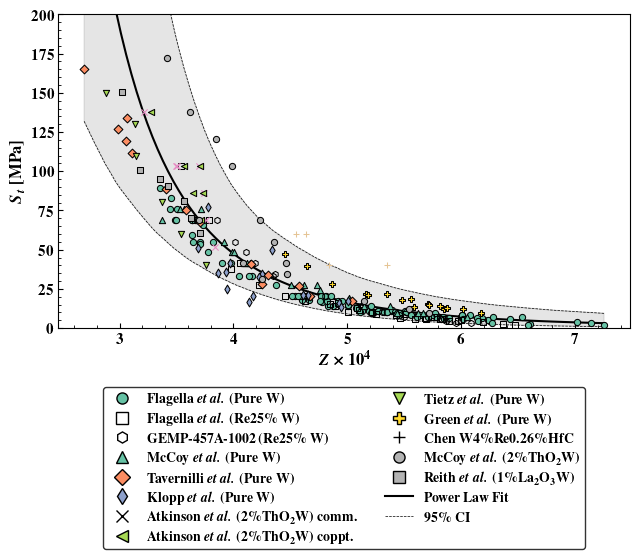

In [3]:
from matplotlib.lines import Line2D 

files = ['flagella/pureWsheet.csv',
         'flagella/Re25WSheet.csv',
         'GEMP-457A-1002/Re25WSheet.csv',
         'McCoy/PureWSheet.csv',
         'tavernilli/pureWSheet.csv',
         'klopp/pureWArcMelted.csv']

labels = ['Flagella et al. (Pure W)',
          r'Flagella et al. (Re25\% W)',
          r'GEMP-457A-1002 (Re25\% W)',
          'McCoy et al. (Pure W)',
          'Tavernilli et al. (Pure W)',
          'Klopp et al. (Pure W)']

files += ['atkinson/2pThO2WRod_comm.csv',
         'atkinson/2pThO2WRod_copt.csv',
         'tietz/PureWRod.csv',
         'green/PureWRod.csv',
         'chen/W4Re026HfC.csv',
         'McCoy/W2pThO2Rod.csv',
         'rieth/WL10Rod.csv'
]

labels += [r'Atkinson et al. (2\%ThO$_2$W) comm.',
          r'Atkinson et al. (2\%ThO$_2$W) coppt.',
          r'Tietz et al. (Pure W)',
          r'Green et al. (Pure W)',
          r'Chen W$4$\%Re$0.26$\%HfC',
          r'McCoy et al. (2\%ThO$_2$W)',
         r'Reith et al. (1\%La$_2$O$_3$W)',]


t_list,T_list,S_list = [],[],[]
for file in files:
    df = pd.read_csv(paths.CREEP_DATA / file,header = 0,na_values = ['-'])
    df = get_creep_rupture_data(df)
    df.dropna(inplace = True)
    t_list.append(df['Rupture Time [s]'].to_numpy())
    T_list.append(df['Temperature [C]'].to_numpy())
    S_list.append(df['Stress [MPa]'].to_numpy())

 
overall_model = LarsonMillerPowerLawMulti(
)
overall_model.fit(
    t_list,
    T_list,
    S_list,
    weight = True
)

print(overall_model.param_confint())
models = {file: m for m,file in zip(overall_model.fit_models(t_list,
                          T_list,
                          S_list,
                          ),files)}

fig, ax_ = plt.subplots(2, 1, figsize=(6.5, 5.75),height_ratios= [1,0.4])
ax,lax = ax_
setup_axis_default(ax)

markers = ['o','s','h','^','D','d','x','<','v','P','+','o','s','H']
sizes = [20]*len(markers)
sizes[-1] = 50
colors = list(plt.get_cmap('Set2')(np.linspace(0, 1, len(files)-2)))
colors = colors[0:1] + [(1,1,1,0)] *2 + colors[1:]
param_est = []
min_lmp = float('inf')
max_lmp = float('-inf')
k = 1
for file,marker,label,color,size in zip(files,markers,labels,colors,sizes):
    data = pd.read_csv(paths.CREEP_DATA / file,header = 0,na_values = ['-'])

    data = get_creep_rupture_data(data)
    data.dropna(inplace = True)


    model = models[file]

    lmp,lmp_conf = model.get_lmp(
    t = data['Rupture Time [s]'],
    T = data['Temperature [C]'],
    conf_int = True
    )
    min_lmp = min(min_lmp,lmp.min())
    max_lmp = max(max_lmp,lmp.max())

    ax.scatter(
        lmp/10**4, data['Stress [MPa]'],
        label = label,
        color = color,
        s = size,
        edgecolor = 'k',
        marker = marker,
        lw = 0.75,
        zorder = 100 + k,
    )
    k+=1

    
lmp_plot = np.linspace(
    min_lmp,
    max_lmp,
    100
)

St_plot,St_conf_int  = overall_model.predict_from_lmp_aggregate(
    Z = lmp_plot,
    conf_int = True,
    alpha = 0.05
)

ax.plot(lmp_plot*1e-4,St_plot,lw = 1.5, color = 'k')
ax.fill_between(
    lmp_plot*1e-4,
    St_conf_int[0],
    St_conf_int[1],
    color = 'grey',
    alpha = 0.2,
)
ax.plot(lmp_plot*1e-4,St_conf_int[0],lw = 0.5, color = 'k', ls = '--')
ax.plot(lmp_plot*1e-4,St_conf_int[1],lw = 0.5, color = 'k', ls = '--')

handles = [Line2D([], [], marker=marker, color='w', label= r'\textbf{' + label.replace('et al.',r'\textit{et al.}') + '}', 
                      markerfacecolor=color, markersize=8,markeredgecolor = 'k') for marker,color,label in zip(markers,colors,labels)]

handles += [Line2D([], [], color = 'k', lw = 1.5, label = r'\textbf{Power Law Fit}')]
handles += [Line2D([], [], color = 'k', ls = '--',lw = 0.5, label = r'\textbf{95\% CI}')]

legend = lax.legend(handles = handles,loc = 'center',ncols = 2,fontsize = 10)
frame = legend.get_frame()
frame.set_linewidth(1.)
frame.set_edgecolor('k')
lax.axis('off') 
ax.set_ylim([0,200])

ax.set_xlabel(r"$Z \times 10^4$",fontsize = 12)    
ax.set_ylabel(r"\textbf{$S_t$ [MPa]}",fontsize = 12)

fig.tight_layout()
fig.savefig(paths.IMAGES /'overall_lmp_creep_fit.svg',bbox_inches = 'tight')


### Pure Tungsten, Large Amount of Data



                        LS         lower         upper
C             1.264000e+01  1.106000e+01  1.451000e+01
A_1_source0   4.096633e+22  4.616046e+21  3.643194e+23
beta_source0 -4.570000e+00 -4.760000e+00 -4.360000e+00
A_1_source1   1.053472e+28  1.491031e+26  4.509363e+29
beta_source1 -5.730000e+00 -6.090000e+00 -5.330000e+00
A_1_source2   9.377282e+31  1.838147e+30  4.352109e+33
beta_source2 -6.570000e+00 -6.920000e+00 -6.190000e+00
A_1_source3   1.365502e+22  1.719304e+20  6.641824e+23
beta_source3 -4.450000e+00 -4.820000e+00 -4.030000e+00
A_1_source4   2.297266e+19  5.981891e+17  1.599791e+21
beta_source4 -3.850000e+00 -4.250000e+00 -3.500000e+00
A_1_source5   1.185565e+25  2.863855e+19  1.230620e+31
beta_source5 -5.120000e+00 -6.440000e+00 -3.880000e+00


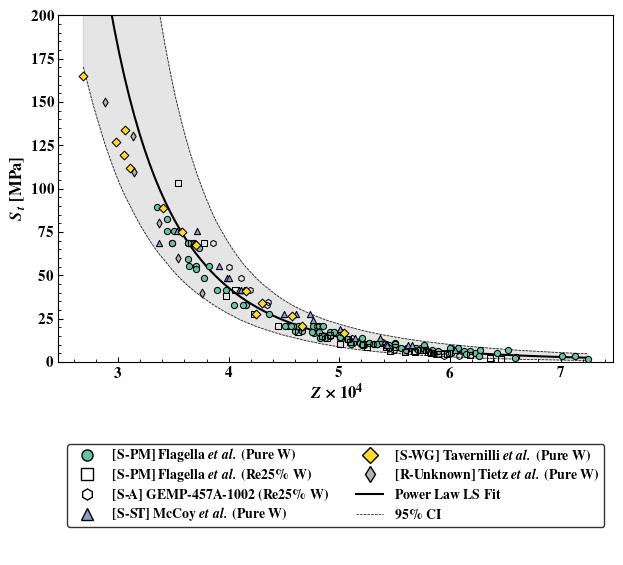

In [4]:
from matplotlib.lines import Line2D 

files = ['flagella/pureWsheet.csv',
         'flagella/Re25WSheet.csv',
         'GEMP-457A-1002/Re25WSheet.csv',
         'McCoy/PureWSheet.csv',
         'tavernilli/pureWSheet.csv',
          'tietz/PureWRod.csv']

labels = ['[S-PM] Flagella et al. (Pure W)',
          r'[S-PM] Flagella et al. (Re25\% W)',
          r'[S-A] GEMP-457A-1002 (Re25\% W)',
          '[S-ST] McCoy et al. (Pure W)',
          '[S-WG] Tavernilli et al. (Pure W)',
          r'[R-Unknown] Tietz et al. (Pure W)',]

labels += [r'Atkinson et al. (2\%ThO$_2$W) comm.',
          r'Atkinson et al. (2\%ThO$_2$W) coppt.',
          r'Tietz et al. (Pure W)',
          r'Green et al. (Pure W)',
          r'Chen W$4$\%Re$0.26$\%HfC',
          r'McCoy et al. (2\%ThO$_2$W)',
         r'Reith et al. (1\%La$_2$O$_3$W)',]


t_list,T_list,S_list = [],[],[]
for file in files:
    df = pd.read_csv(paths.CREEP_DATA / file,header = 0,na_values = ['-'])
    df = get_creep_rupture_data(df)
    df.dropna(inplace = True)
    t_list.append(df['Rupture Time [s]'].to_numpy())
    T_list.append(df['Temperature [C]'].to_numpy())
    S_list.append(df['Stress [MPa]'].to_numpy())

 
overall_model = LarsonMillerPowerLawMulti(
)
overall_model.fit(
    t_list,
    T_list,
    S_list,
    weight = True
)


pc = overall_model.param_confint()
params = pd.Series(overall_model.params(),name = 'LS')
params = pd.concat([params.to_frame(),pc],axis = 1)
print(np.round(params,2))
C_ml = overall_model.params()["C"]
C_bs_ = overall_model.bootstrap_params_[:, 0].copy()

models = {file: m for m,file in zip(overall_model.fit_models(t_list,
                          T_list,
                          S_list,
                          ),files)}

fig, ax_ = plt.subplots(2, 1, figsize=(6.5, 5.75),height_ratios= [1,0.4])
ax,lax = ax_
setup_axis_default(ax)

markers = ['o','s','h','^','D','d','x','<','v','P','+','o','s','H']
sizes = [20]*len(markers)
sizes[-1] = 50
colors = list(plt.get_cmap('Set2')(np.linspace(0, 1, len(files)-2)))
colors = colors[0:1] + [(1,1,1,0)] *2 + colors[1:]
param_est = []
min_lmp = float('inf')
max_lmp = float('-inf')
k = 1
for file,marker,label,color,size in zip(files,markers,labels,colors,sizes):
    data = pd.read_csv(paths.CREEP_DATA / file,header = 0,na_values = ['-'])

    data = get_creep_rupture_data(data)
    data.dropna(inplace = True)


    model = models[file]

    lmp,lmp_conf = model.get_lmp(
    t = data['Rupture Time [s]'],
    T = data['Temperature [C]'],
    conf_int = True
    )
    min_lmp = min(min_lmp,lmp.min())
    max_lmp = max(max_lmp,lmp.max())

    ax.scatter(
        lmp/10**4, data['Stress [MPa]'],
        label = label,
        color = color,
        s = size,
        edgecolor = 'k',
        marker = marker,
        lw = 0.75,
        zorder = 100 + k,
    )
    k+=1

    
lmp_plot = np.linspace(
    min_lmp,
    max_lmp,
    100
)

St_plot,St_conf_int  = overall_model.predict_from_lmp_aggregate(
    Z = lmp_plot,
    conf_int = True,
    alpha = 0.05
)

ax.plot(lmp_plot*1e-4,St_plot,lw = 1.5, color = 'k')
ax.fill_between(
    lmp_plot*1e-4,
    St_conf_int[0],
    St_conf_int[1],
    color = 'grey',
    alpha = 0.2,
)
ax.plot(lmp_plot*1e-4,St_conf_int[0],lw = 0.5, color = 'k', ls = '--')
ax.plot(lmp_plot*1e-4,St_conf_int[1],lw = 0.5, color = 'k', ls = '--')

handles = [Line2D([], [], marker=marker, color='w', label= r'\textbf{' + label.replace('et al.',r'\textit{et al.}') + '}', 
                      markerfacecolor=color, markersize=8,markeredgecolor = 'k') for marker,color,label in zip(markers,colors,labels)]

handles += [Line2D([], [], color = 'k', lw = 1.5, label = r'\textbf{Power Law LS Fit}')]
handles += [Line2D([], [], color = 'k', ls = '--',lw = 0.5, label = r'\textbf{95\% CI}')]

legend = lax.legend(handles = handles,loc = 'center',ncols = 2,fontsize = 10)
frame = legend.get_frame()
frame.set_linewidth(1.)
frame.set_edgecolor('k')
lax.axis('off') 
ax.set_ylim([0,200])

ax.set_xlabel(r"$Z \times 10^4$",fontsize = 12)    
ax.set_ylabel(r"\textbf{$S_t$ [MPa]}",fontsize = 12)

fig.tight_layout()
fig.savefig(paths.IMAGES /'base_line_w_fit.svg',bbox_inches = 'tight')


### Alloyed Tungsten

Use estimated C from pure W for alloys

                        LS         lower         upper
C             1.273000e+01  1.106000e+01  1.451000e+01
A_1_source0   4.191475e+22  4.616046e+21  3.643194e+23
beta_source0 -4.570000e+00 -4.760000e+00 -4.360000e+00
A_1_source1   1.079840e+28  1.491031e+26  4.509363e+29
beta_source1 -5.730000e+00 -6.090000e+00 -5.330000e+00
A_1_source2   9.536890e+31  1.838147e+30  4.352109e+33
beta_source2 -6.560000e+00 -6.920000e+00 -6.190000e+00
A_1_source3   1.449202e+22  1.719304e+20  6.641824e+23
beta_source3 -4.450000e+00 -4.820000e+00 -4.030000e+00
A_1_source4   2.369961e+19  5.981891e+17  1.599791e+21
beta_source4 -3.850000e+00 -4.250000e+00 -3.500000e+00
A_1_source5   1.281557e+25  2.863855e+19  1.230620e+31
beta_source5 -5.130000e+00 -6.440000e+00 -3.880000e+00


/home/mlanahan/Documents/projects/modeling_tungsten/engineering_models/modeling/creeplib.py:1047: RuntimeWarning: overflow encountered in power
  S_pred_b = np.exp(alpha_b) * (Z ** beta_b)
/home/mlanahan/Documents/projects/modeling_tungsten/engineering_models/modeling/creeplib.py:1047: RuntimeWarning: invalid value encountered in multiply
  S_pred_b = np.exp(alpha_b) * (Z ** beta_b)
/home/mlanahan/Documents/projects/modeling_tungsten/engineering_models/modeling/creeplib.py:1047: RuntimeWarning: overflow encountered in exp
  S_pred_b = np.exp(alpha_b) * (Z ** beta_b)


Mean Creep Rupture Strength [MPa]
                 LS     LB      UB
Temperature                       
1000         181.45  98.46  449.42
1100         111.82  64.11  242.57
[R-ST] McCoy et al. (2\%ThO$_2$W)Creep Rupture Strength [MPa]
                 LS      LB      UB
Temperature                        
1000         337.91  198.58  634.26
1100         200.18  124.01  363.98

[R-WE] Reith et al. (1\%La$_2$O$_3$W)Creep Rupture Strength [MPa]
                 LS      LB      UB
Temperature                        
1000         144.37  107.62  197.45
1100         100.29   79.75  132.97



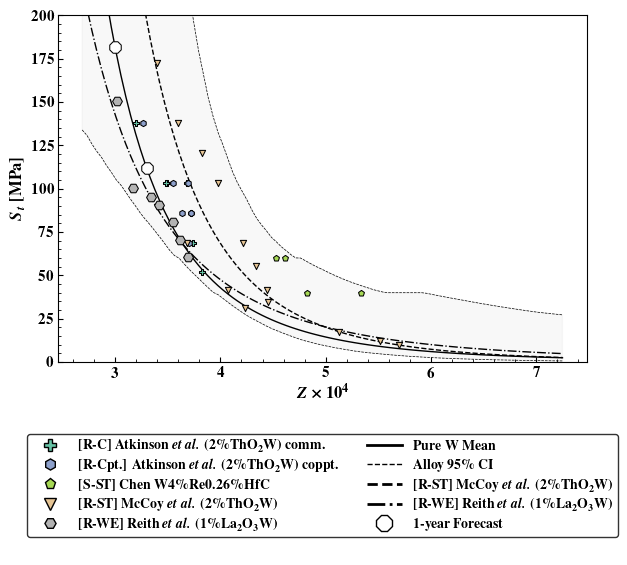

In [5]:
from matplotlib.lines import Line2D 

files = ['atkinson/2pThO2WRod_comm.csv',
         'atkinson/2pThO2WRod_copt.csv',
         'chen/W4Re026HfC.csv',
         'McCoy/W2pThO2Rod.csv',
         'rieth/WL10Rod.csv'
]

labels = [r'[R-C] Atkinson et al. (2\%ThO$_2$W) comm.',
          r'[R-Cpt.] Atkinson et al. (2\%ThO$_2$W) coppt.',
          r'[S-ST] Chen W$4$\%Re$0.26$\%HfC',
          r'[R-ST] McCoy et al. (2\%ThO$_2$W)',
         r'[R-WE] Reith et al. (1\%La$_2$O$_3$W)']


t_list,T_list,S_list = [],[],[]
for file in files:
    df = pd.read_csv(paths.CREEP_DATA / file,header = 0,na_values = ['-'])
    df = get_creep_rupture_data(df)
    df.dropna(inplace = True)
    t_list.append(df['Rupture Time [s]'].to_numpy())
    T_list.append(df['Temperature [C]'].to_numpy())
    S_list.append(df['Stress [MPa]'].to_numpy())

 
overall_model_alloy = LarsonMillerPowerLawMulti(C_fixed = C_ml,C_bootstrap= C_bs_.copy())
overall_model_alloy.fit(
    t_list,
    T_list,
    S_list,
    weight = True
)


pc = overall_model.param_confint()
params = pd.Series(overall_model.params(),name = 'LS')
params = pd.concat([params.to_frame(),pc],axis = 1)
print(np.round(params,2))

alloy_models = {file: m for m,file in zip(overall_model_alloy.fit_models(t_list,
                          T_list,
                          S_list,
                          ),files)}

fig, ax_ = plt.subplots(2, 1, figsize=(6.5, 5.75),height_ratios= [1,0.4])
ax,lax = ax_
setup_axis_default(ax)

markers = ['P','h','p','v','H']
sizes = [20]*len(markers)
sizes[-1] = 50
colors = list(plt.get_cmap('Set2')(np.linspace(0, 1, len(files))))
param_est = []
min_lmp = float('inf')
max_lmp = float('-inf')
k = 1
for file,marker,label,color,size in zip(files,markers,labels,colors,sizes):
    data = pd.read_csv(paths.CREEP_DATA / file,header = 0,na_values = ['-'])

    data = get_creep_rupture_data(data)
    data.dropna(inplace = True)


    model = alloy_models[file]

    lmp,lmp_conf = model.get_lmp(
    t = data['Rupture Time [s]'],
    T = data['Temperature [C]'],
    conf_int = True
    )
    min_lmp = min(min_lmp,lmp.min())
    max_lmp = max(max_lmp,lmp.max())

    ax.scatter(
        lmp/10**4, data['Stress [MPa]'],
        label = label,
        color = color,
        s = size,
        edgecolor = 'k',
        marker = marker,
        lw = 0.75,
        zorder = 100 + k,
    )
    k+=1

    
#plot alloy confidence intervals
St_plot,St_conf_int  = overall_model_alloy.predict_from_lmp_aggregate(
    Z = lmp_plot,
    conf_int = True,
    alpha = 0.05
)
ax.fill_between(
    lmp_plot*1e-4,
    St_conf_int[0],
    St_conf_int[1],
    color = 'grey',
    alpha = 0.05,
)
ax.plot(lmp_plot*1e-4,St_conf_int[0],lw = 0.5, color = 'k', ls = '--')
ax.plot(lmp_plot*1e-4,St_conf_int[1],lw = 0.5, color = 'k', ls = '--')

#plot overall pure W mean
St_plot,St_conf_int  = overall_model.predict_from_lmp_aggregate(
    Z = lmp_plot,
    conf_int = True,
    alpha = 0.05
)

ax.plot(lmp_plot*1e-4,St_plot,lw = 1.0, color = 'k')

#plot specific alloy means
plot_files = ['McCoy/W2pThO2Rod.csv',
              'rieth/WL10Rod.csv']

for ls,file in zip(['--','-.'],plot_files):
    model = alloy_models[file]
    St_plot = model.predict_from_lmp(lmp_plot)
    ax.plot(lmp_plot*1e-4,St_plot,lw = 1.0, color = 'k',ls = ls)

#markers showing forecasted data 
seconds_to_year= 60*60*24*365
T_forecast = np.array([1000,1100]) 
t_forecast = np.ones(T_forecast.shape[0]) * seconds_to_year

St_forecast,St_c_forecast = overall_model.get_prediction_aggregate(t_forecast,T_forecast,conf_int= True)
ax.scatter(
    overall_model.get_lmp(
        t = t_forecast,
        T = T_forecast
    )/10**4,
    St_forecast,
    label = 'Forecasted',
    s = 80,
    edgecolor = 'k',
    marker = '8',
    lw = 0.75,
    zorder = 300,
    facecolor = 'w')

forecast = pd.DataFrame(np.array([St_forecast,St_c_forecast[0],St_c_forecast[1]]).T,
                        columns = ['LS','LB','UB'],
                        index = pd.Series(T_forecast,name = 'Temperature'))
print('Mean Creep Rupture Strength [MPa]')
print(np.round(forecast,2)) 

for file,label in zip(plot_files,labels[-2:]):
    model = alloy_models[file]
    St_forecast,St_c_forecast = model.get_prediction(t_forecast,T_forecast,conf_int= True)
    forecast = pd.DataFrame(np.array([St_forecast,St_c_forecast[0],St_c_forecast[1]]).T,
                            columns = ['LS','LB','UB'],
                            index = pd.Series(T_forecast,name = 'Temperature'))
    print(label + 'Creep Rupture Strength [MPa]')
    print(np.round(forecast,2))
    print('')



handles = [Line2D([], [], marker=marker, color='w', label= r'\textbf{' + label.replace('et al.',r'\textit{et al.}') + '}', 
                      markerfacecolor=color, markersize=8,markeredgecolor = 'k') for marker,color,label in zip(markers,colors,labels)]

handles += [Line2D([], [], color = 'k', lw = 2, label = r'\textbf{Pure W Mean}')]
handles += [Line2D([], [], color = 'k', ls = '--',lw = 1, label = r'\textbf{Alloy 95\% CI}')]
handles += [
    Line2D([], [], color = 'k', ls = ls ,lw = 2,
           label = r'\textbf{' + label.replace('et al.',r'\textit{et al.}') + '}') for ls,label in zip(['--','-.'],labels[-2:])
]
handles += [Line2D([], [], marker='8', color='w', label= r'\textbf{1-year Forecast}',
                      markerfacecolor='w', markersize=12,markeredgecolor = 'k')]
legend = lax.legend(handles = handles,loc = 'center',ncols = 2,fontsize = 10,handlelength = 2.5)
frame = legend.get_frame()
frame.set_linewidth(1.)
frame.set_edgecolor('k')
lax.axis('off') 
ax.set_ylim([0,200])

ax.set_xlabel(r"$Z \times 10^4$",fontsize = 12)    
ax.set_ylabel(r"\textbf{$S_t$ [MPa]}",fontsize = 12)

fig.tight_layout()
fig.savefig(paths.IMAGES /'w_alloy_fit.svg',bbox_inches = 'tight')

### Tungsten Wire

   Stress [MPa]  Temperature [C]  Rupture Time [s]
0   1413.425800       648.888889            2160.0
1   1378.952000       648.888889            1800.0
2   1351.366065       648.888889            3240.0
3   1310.004400       648.888889           18000.0
4   1275.530600       648.888889           18000.0
McCoy et al. (Pure W)
                  LS         lower         upper
A_1     5.132908e+11  1.495423e+11  1.892770e+12
beta_1 -2.035276e+00 -2.163693e+00 -1.915679e+00
C       1.484003e+01  1.116087e+01  2.128096e+01



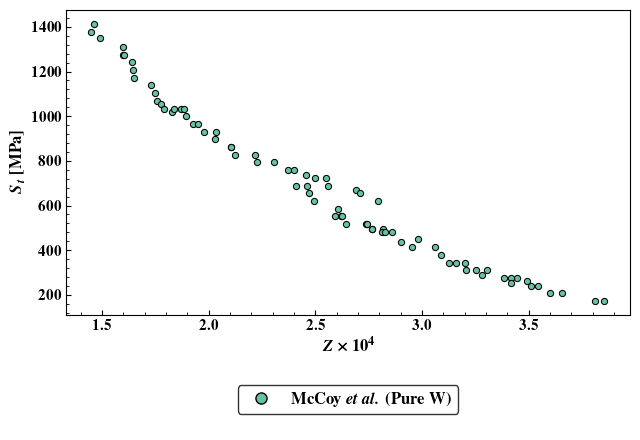

In [ ]:
from matplotlib.lines import Line2D 

files = ['McCoy/PureWWire.csv']

labels = ['McCoy et al. (Pure W)']

fig, ax_ = plt.subplots(2, 1, figsize=(6.5, 4.5),height_ratios= [1,0.2])
ax,lax = ax_
setup_axis_default(ax)

markers = ['o','s','h','^','D','d']
colors = list(plt.get_cmap('Set2')(np.linspace(0, 1, len(files))))
param_est = []
for file,marker,label,color in zip(files,markers,labels,colors):

    data = pd.read_csv(paths.CREEP_DATA / file,header = 0,na_values = ['-'])
    data = get_creep_rupture_data(data)

    print(data.head())
    data.dropna(inplace = True)

    model = LarsonMillerPowerLaw()
    model.fit(
        t = data['Rupture Time [s]'],
        T = data['Temperature [C]'],
        S_t = data['Stress [MPa]'],
    )

    lmp = model.lmp(
        t = data['Rupture Time [s]'],
        T = data['Temperature [C]'],
        C = model.C
    )

    lmp_plot = np.linspace(
        lmp.min(),
        lmp.max(),
        100
    )

    St_plot,St_conf_int  = model.predict_from_lmp(
        Z = lmp_plot,
        conf_int = True,
        alpha = 0.5
    )

    lmp,lmp_conf = model.get_lmp(
    t = data['Rupture Time [s]'],
    T = data['Temperature [C]'],
    conf_int = True
    )

    ax.scatter(
        lmp/10**4, data['Stress [MPa]'],
        label = label,
        color = color,
        s = 20,
        edgecolor = 'k',
        marker = marker,
        lw = 0.75
    )

    
    pconf = model.param_confint(alpha = 0.05)
    params = pd.concat([model.params().rename('LS').to_frame(),pconf],axis = 1)   
    print(label)
    print(params)
    print('')

legend = lax.legend(
    handles = [Line2D([], [], marker=marker, color='w', label= r'\textbf{' + label.replace('et al.',r'\textit{et al.}') + '}', 
                      markerfacecolor=color, markersize=8,markeredgecolor = 'k') for marker,color,label in zip(markers,colors,labels)],
                      loc = 'center',ncols = 2,fontsize = 12
)
frame = legend.get_frame()
frame.set_linewidth(1.)
frame.set_edgecolor('k')
lax.axis('off') 

ax.set_xlabel(r"$Z \times 10^4$",fontsize = 12)    
ax.set_ylabel(r"\textbf{$S_t$ [MPa]}",fontsize = 12)

fig.tight_layout()


### Rod

   Test Temperature (F) Specimen  Stress (psi)  Rupture Time (hrs)
0                  2700       X2         20000                 2.1
1                  2700       X1         15000                15.0
2                  2700       X3         15000                14.0
3                  2700       X4         10000                83.0
4                  3000       8D         15000                 4.4


/home/mlanahan/Documents/projects/modeling_tungsten/engineering_models/modeling/creeplib.py:560: RuntimeWarning: overflow encountered in exp
  S_b = np.exp(alpha_b) * (Z ** beta_b)
/home/mlanahan/Documents/projects/modeling_tungsten/engineering_models/modeling/creeplib.py:560: RuntimeWarning: invalid value encountered in multiply
  S_b = np.exp(alpha_b) * (Z ** beta_b)
/home/mlanahan/Documents/projects/modeling_tungsten/engineering_models/modeling/creeplib.py:487: RuntimeWarning: overflow encountered in exp
  A1_samples = np.exp(alpha_samples)  # A_1 = e^(alpha)


Atkinson et al. (2\%ThO$_2$W) comm.
                  LS         lower         upper
A_1     5.155612e+19  1.751450e-10  2.864191e+40
beta_1 -3.997323e+00 -9.034634e+00  1.427874e+00
C       7.412906e+00  1.000006e+00  1.000000e+05

   Test Temperature (F) Specimen  Stress (psi)  Rupture Time (hrs)
0                  2700       Y8         20000                 3.2
1                  2700       Y7         15000                58.0
2                  2700       Z8         12500                71.0
3                  3000       3D         15000                 2.0
4                  3000       4D         12500                 3.3


/home/mlanahan/Documents/projects/modeling_tungsten/engineering_models/modeling/creeplib.py:560: RuntimeWarning: overflow encountered in exp
  S_b = np.exp(alpha_b) * (Z ** beta_b)
/home/mlanahan/Documents/projects/modeling_tungsten/engineering_models/modeling/creeplib.py:560: RuntimeWarning: invalid value encountered in multiply
  S_b = np.exp(alpha_b) * (Z ** beta_b)
/home/mlanahan/Documents/projects/modeling_tungsten/engineering_models/modeling/creeplib.py:487: RuntimeWarning: overflow encountered in exp
  A1_samples = np.exp(alpha_samples)  # A_1 = e^(alpha)
/home/mlanahan/.local/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Atkinson et al. (2\%ThO$_2$W) coppt.
                  LS        lower         upper
A_1     2.634551e+25     0.000245           NaN
beta_1 -4.977892e+00 -9409.518221      0.684490
C       2.241393e+01     1.000006  99999.997575

   Test Temperature (C)  Rupture Time (hr)   Stress (MPa)
0                  1100         194.992915     150.160855
1                  1100        1891.629848     130.141169
2                  1300          25.848145     109.864865
3                  1300         150.322670      80.148005
4                  1300         552.072651      60.026144


/home/mlanahan/Documents/projects/modeling_tungsten/engineering_models/modeling/creeplib.py:560: RuntimeWarning: overflow encountered in exp
  S_b = np.exp(alpha_b) * (Z ** beta_b)
/home/mlanahan/Documents/projects/modeling_tungsten/engineering_models/modeling/creeplib.py:560: RuntimeWarning: invalid value encountered in multiply
  S_b = np.exp(alpha_b) * (Z ** beta_b)
/home/mlanahan/Documents/projects/modeling_tungsten/engineering_models/modeling/creeplib.py:487: RuntimeWarning: overflow encountered in exp
  A1_samples = np.exp(alpha_samples)  # A_1 = e^(alpha)
/home/mlanahan/.local/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Tietz et al. (Pure W)
                  LS         lower         upper
A_1     3.623062e+25  7.070451e+18           NaN
beta_1 -5.206491e+00 -2.144831e+04     -3.755996
C       1.397653e+01  2.864767e+00  99998.863873

   Test Temperature (C)  Rupture Time (hr)   Stress (MPa)
0                  1100         709.944020     150.599988
1                  1300          34.712800     100.649747
2                  1300         129.716240      95.217505
3                  1300         225.969052      90.606075
4                  1300         645.346329      80.853222


/home/mlanahan/Documents/projects/modeling_tungsten/engineering_models/modeling/creeplib.py:560: RuntimeWarning: overflow encountered in exp
  S_b = np.exp(alpha_b) * (Z ** beta_b)
/home/mlanahan/Documents/projects/modeling_tungsten/engineering_models/modeling/creeplib.py:560: RuntimeWarning: invalid value encountered in multiply
  S_b = np.exp(alpha_b) * (Z ** beta_b)
/home/mlanahan/Documents/projects/modeling_tungsten/engineering_models/modeling/creeplib.py:487: RuntimeWarning: overflow encountered in exp
  A1_samples = np.exp(alpha_samples)  # A_1 = e^(alpha)
/home/mlanahan/.local/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Reith et al. (1\%La$_2$O$_3$W)
                  LS         lower         upper
A_1     3.633447e+21  8.547129e+18           NaN
beta_1 -4.218129e+00 -1.626360e+04     -3.611545
C       2.101478e+01  7.436715e+00  99999.368502

   Temperature (F)  Rupture Time (hr)  Stress (ksi)
0             5070           0.336858      2.653000
1             5070           0.585256      2.250254
2             5070           1.746677      1.806719
3             5070           3.069307      1.407045
4             4890           0.328054      3.166209
Green et al. (Pure W)
                  LS         lower         upper
A_1     4.135307e+20  3.099416e+16  1.035941e+22
beta_1 -4.221740e+00 -4.491651e+00 -3.391133e+00
C       6.598555e+00  3.839585e+00  9.285178e+00



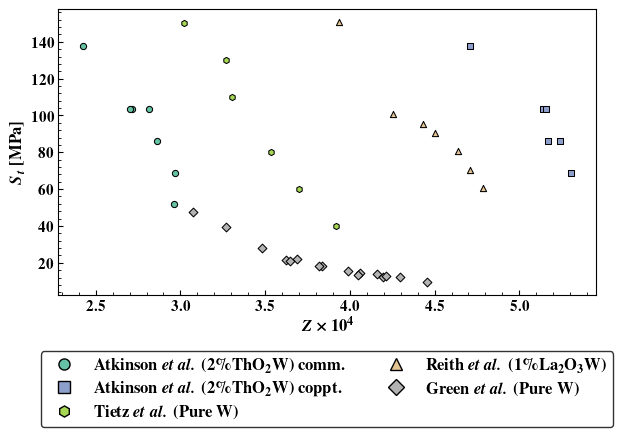

In [ ]:
from matplotlib.lines import Line2D 

files = ['atkinson/2pThO2WRod_comm.csv',
         'atkinson/2pThO2WRod_copt.csv',
         'tietz/PureWRod.csv',
         'rieth/WL10Rod.csv',
         'green/PureWRod.csv',]

labels = [r'Atkinson et al. (2\%ThO$_2$W) comm.',
          r'Atkinson et al. (2\%ThO$_2$W) coppt.',
          r'Tietz et al. (Pure W)',
          r'Reith et al. (1\%La$_2$O$_3$W)',
          r'Green et al. (Pure W)']

fig, ax_ = plt.subplots(2, 1, figsize=(6.5, 4.5),height_ratios= [1,0.2])
ax,lax = ax_
setup_axis_default(ax)

markers = ['o','s','h','^','D','d']
colors = list(plt.get_cmap('Set2')(np.linspace(0, 1, len(files))))
param_est = []
for file,marker,label,color in zip(files,markers,labels,colors):

    data = pd.read_csv(paths.CREEP_DATA / file,header = 0,na_values = ['-'])
    print(data.head())
    data = get_creep_rupture_data(data)
    data.dropna(inplace = True)

    model = LarsonMillerPowerLaw()
    model.fit(
        t = data['Rupture Time [s]'],
        T = data['Temperature [C]'],
        S_t = data['Stress [MPa]'],
        method_bounds= (1,1e5)
    )

    lmp = model.lmp(
        t = data['Rupture Time [s]'],
        T = data['Temperature [C]'],
        C = model.C
    )

    lmp_plot = np.linspace(
        lmp.min(),
        lmp.max(),
        100
    )

    St_plot,St_conf_int  = model.predict_from_lmp(
        Z = lmp_plot,
        conf_int = True,
        alpha = 0.5
    )

    lmp,lmp_conf = model.get_lmp(
    t = data['Rupture Time [s]'],
    T = data['Temperature [C]'],
    conf_int = True
    )

    ax.scatter(
        lmp/10**4, data['Stress [MPa]'],
        label = label,
        color = color,
        s = 20,
        edgecolor = 'k',
        marker = marker,
        lw = 0.75
    )

    
    pconf = model.param_confint(alpha = 0.05)
    params = pd.concat([model.params().rename('LS').to_frame(),pconf],axis = 1)   
    print(label)
    print(params)
    print('')

legend = lax.legend(
    handles = [Line2D([], [], marker=marker, color='w', label= r'\textbf{' + label.replace('et al.',r'\textit{et al.}') + '}', 
                      markerfacecolor=color, markersize=8,markeredgecolor = 'k') for marker,color,label in zip(markers,colors,labels)],
                      loc = 'center',ncols = 2,fontsize = 12
)
frame = legend.get_frame()
frame.set_linewidth(1.)
frame.set_edgecolor('k')
lax.axis('off') 

ax.set_xlabel(r"$Z \times 10^4$",fontsize = 12)    
ax.set_ylabel(r"\textbf{$S_t$ [MPa]}",fontsize = 12)

fig.tight_layout()
